In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sci
import scipy.optimize as opt
from scipy.interpolate import interp1d
np.set_printoptions(threshold=np.inf)

# Experiment 1: Diverging lens in water

First, we define functions which return us the radius of curvature as well as the focal length of our lenses underwater.

In [24]:
def curvature(h, d) -> float:
    return np.sqrt(h**2 + d**2) * d/h


def focal_length(R, n_lens, n_out) -> float:
    return (((n_lens - n_out)/n_out) *(2/R))**(-1)





In [25]:
# Properties of converging lens
R_converging = curvature(0.54, 1.6)
f_converging_water = focal_length(R_converging, 1.5, 1.33)

# Properties of diverging lens
R_diverging = curvature(0.46, 5.7)
f_diverging_water = focal_length(-R_diverging, 1, 1.33)

d_oc = 17.8
separation = np.array([23.7, 28.0, 31.8, 34.8, 38.2, 42.9])

separation = [separation[i] - d_oc for i in range(len(separation))]

def image_distance(d_oc: float, separation: list[float]) -> list[float]: 
    d_ic = [f_converging_water * d_oc/(d_oc - f_converging_water)] * 6
    d_ic = [d_ic[i] + separation[i] for i in range(len(d_ic))]

    d_ib = []
    for i in range(len(separation)):
        d_ib.append(f_diverging_water * d_ic[i]/(d_ic[i] - f_diverging_water))
    return d_ib


d_image = image_distance(d_oc, separation)

distance = [23.7, 28.0, 31.8, 34.8, 38.2, 42.9]

print(f"Calculated distances between diverging lens and screen: {d_image}")

print(f"Mean increment in image distance: {np.mean(np.diff(d_image))}")
print(f"Mean increment in actual distance: {np.mean(np.diff(distance))}")






Calculated distances between diverging lens and screen: [81.64696996580845, 80.8481774186423, 80.12469379430593, 79.54147401022611, 78.8672288693925, 77.91116087670817]
Mean increment in image distance: -0.7471618178200572
Mean increment in actual distance: 3.84
19.5723624568119


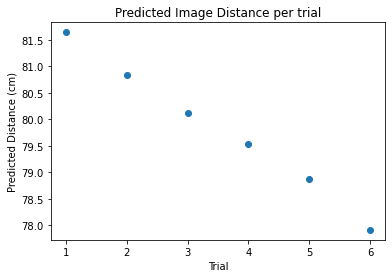

In [26]:
plt.scatter([1, 2, 3, 4, 5, 6], d_image)
plt.title("Predicted Image Distance per trial")
plt.xlabel("Trial")
plt.ylabel("Predicted Distance (cm)")
plt.show()


## Experiment 1 Error Prop

In [27]:
# Distances
alpha_d_oc = 0.1 # was 0.5
alpha_d_fb = 0.1 # was 0.5

# Measurements for lenses
alpha_d_c = 0.1 # distance of convex lens
alpha_d_hc = 0.02 # height of convex lens
alpha_d_b = 0.1 # distance of fishbowl lens
alpha_d_hb = 0.02 # height of fishbowl lens

def curvature_error(h, d, alpha_h, alpha_d) -> tuple: # already have the equation above
    return d * np.sqrt(d**2 + h**2)/h, np.sqrt(np.square((2*d**2 + h**2)/(h * np.sqrt(d**2 + h**2)) * alpha_d) + np.square(d**3/(h**2 * np.sqrt(d**2 + h**2)) * alpha_h))

def focal_length_error(r1, r2, n_lens, n_0, alpha_r1, alpha_r2, alpha_nlens, alpha_n0) -> float: # already have the equation above
    return np.sqrt(np.square(r2**2 * alpha_r1/((n_lens/n_0 - 1)*(1/r1 - 1/r2)**2)) + np.square(r1**2 * alpha_r2/((n_lens/n_0 - 1)*(1/r2 - 1/r1)**2)) + np.square(n_0 * alpha_nlens/((1/r1 - 1/r2)*(n_lens - n_0)**2)) + np.square(n_lens * r1 * r2 * alpha_n0/((1/r2 - 1/r1)*(n_0 - n_lens)**2)))**(-2)

def image_distance_error(f_c, d_oc, alpha_fc, alpha_doc) -> tuple:
    return d_oc * f_c/(d_oc - f_c), np.sqrt(np.square(f_c**2/(d_oc - f_c)**2 * alpha_doc) + np.square(d_oc**2/(d_oc - f_c)**2 * alpha_fc))

def object_distance_error(d_ic, d_fb, d_oc, alpha_dic, alpha_dfb, alpha_doc) -> tuple: 
    return [d_ic - separation[i] for i in range(len(separation))], np.sqrt(alpha_dic**2 + alpha_dfb**2 + alpha_doc**2)


def image_distance_error2(f_c, d_ob, alpha_fc, alpha_doc) -> tuple:
    d_ob = [d_ob[i] * (-1) for i in range(len(d_ob))]

    return [d_ob[i] * f_c/(d_ob[i] - f_c) for i in range(len(d_ob))], [np.sqrt(np.square(f_c**2/(d_ob[i] - f_c)**2 * alpha_doc) + np.square(d_ob[i]**2/(d_ob[i] - f_c)**2 * alpha_fc)) for i in range(len(d_ob))]


def magnification_error(d_ib, d_ob, d_ic, d_oc, alpha_dib, alpha_dob, alpha_dic, alpha_doc) -> tuple:
    return [d_ib[i] * d_ic/(d_ob[i] * d_oc) for i in range(len(d_ob))], [np.sqrt(np.square(d_ic/(d_ob[i]*d_oc) * alpha_dib[i]) + np.square(d_ib[i]/(d_ob[i]*d_oc) * alpha_dic) + np.square(d_ib[i] * d_ic/(d_ob[i]**2 * d_oc) * alpha_dob) + np.square(d_ib[i] * d_ic/(d_ob[i] * d_oc**2) * alpha_doc)) for i in range(len(d_ob))]

R_converging, error_R_converging = curvature_error(0.54, 1.6, alpha_d_hc, alpha_d_c)
R_diverging, error_R_diverging = curvature_error(0.46, 5.7, alpha_d_hb, alpha_d_b)

error_f_converging = focal_length_error(R_converging, -R_converging, 1.5, 1.33, error_R_converging, error_R_converging, 0.02, 0.02)
error_f_diverging = focal_length_error(R_diverging, -R_diverging, 1, 1.33, error_R_diverging, error_R_diverging, 0.02, 0.02)
d_ic, error_d_ic = image_distance_error(f_converging_water, d_oc, error_f_converging, alpha_d_oc)
d_ob, error_d_ob = object_distance_error(d_ic, separation, d_oc, error_d_ic, alpha_d_fb, alpha_d_oc)
d_ib, error_d_ib = image_distance_error2(f_diverging_water, d_ob, error_f_diverging, error_d_ob)
mag, error_mag = magnification_error(d_ib, d_ob, d_ic, d_oc, error_d_ib, error_d_ob, error_d_ic, alpha_d_oc)

print(d_ib, error_d_ib)


[484.4886731721627, 461.5214592699448, 443.6506234030161, 430.8976391848748, 417.6913589793989, 401.31041693562713] [69.83436388181889, 60.761959390191066, 54.13922085443847, 49.64669769283741, 45.19954339740163, 39.97322761444762]


[4.1 3.9 3.5 3.3 3.2 2.9] [0.1 0.1 0.1 0.1 0.1 0.1]


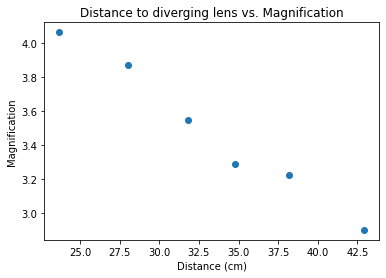

In [28]:
sizeF = [6.3, 6.0, 5.5, 5.1, 5.0, 4.5]
error_sizeF = 0.05
error_imageF = 0.05


def mag_image(hi, ho, alpha_hi, alpha_ho) -> tuple:
    return [hi[i]/ho for i in range(len(hi))], [np.sqrt(np.square(alpha_hi/ho) + np.square(hi[i]/(ho**2) * alpha_ho)) for i in range(len(hi))]

imag, error_imag = mag_image(sizeF, 1.55, 0.05, 0.05)


print(np.round(imag, 1), np.round(error_imag, 1))

plt.scatter(distance, imag)
plt.title("Distance to diverging lens vs. Magnification")
plt.xlabel("Distance (cm)")
plt.ylabel("Magnification")
plt.show()

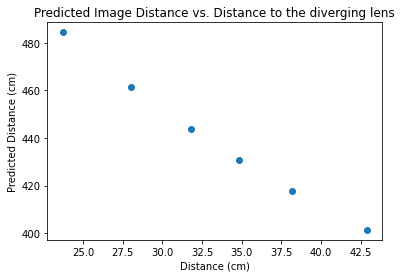

In [29]:
plt.scatter(distance, d_ib)
plt.title("Predicted Image Distance vs. Distance to the diverging lens")
plt.xlabel("Distance (cm)")
plt.ylabel("Predicted Distance (cm)")
plt.show()



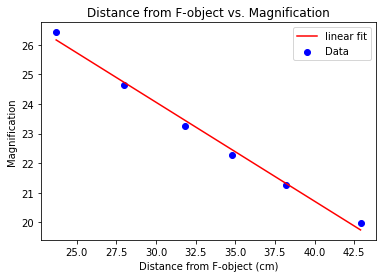

slope: -0.33421556595900875 ± 0.014555017632194847
y-intercept: 34.08615788186513 ± 0.4924251692525944


In [30]:
def linear(x, m, b) -> float: 
    return m * x + b

opti, cov = opt.curve_fit(linear, distance, mag)
m, b = opti
dm, db = np.sqrt(np.diag(cov))

plt.scatter(distance, mag, c = 'b', label = 'Data')
plt.plot(distance, [linear(distance[i], m, b) for i in range(len(distance))], c = 'r', label = 'linear fit')
plt.legend()
plt.title("Distance from F-object vs. Magnification")
plt.xlabel("Distance from F-object (cm)")
plt.ylabel("Magnification")
plt.show()

print(f"slope: {m} \u00b1 {dm}")
print(f"y-intercept: {b} \u00b1 {db}")

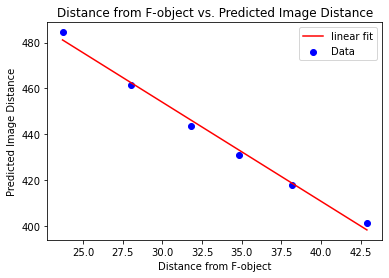

slope: -4.321606251962975 ± 0.18820504092381388
y-intercept: 583.5480762644071 ± 6.367350570356651


In [31]:
opti2, cov = opt.curve_fit(linear, distance, d_ib)
m2, b2 = opti2
dm2, db2 = np.sqrt(np.diag(cov))


plt.scatter(distance, d_ib, c = 'b', label = 'Data')
plt.plot(distance, [linear(distance[i], m2, b2) for i in range(len(distance))], c = 'r', label = 'linear fit')
plt.legend()
plt.title("Distance from F-object vs. Predicted Image Distance")
plt.ylabel("Predicted Image Distance")
plt.xlabel("Distance from F-object")
plt.show()

print(f"slope: {m2} \u00b1 {dm2}")
print(f"y-intercept: {b2} \u00b1 {db2}")


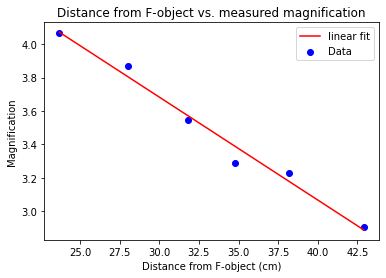

slope: -0.06165223706094262 ± 0.004166449784899693
y-intercept: 5.53278031273393 ± 0.14095927372491635


In [32]:
opti3, cov = opt.curve_fit(linear, distance, imag)
m3, b3 = opti3
dm3, db3 = np.sqrt(np.diag(cov))

plt.scatter(distance, imag, c = 'b', label = 'Data')
plt.plot(distance, [linear(distance[i], m3, b3) for i in range(len(distance))], c = 'r', label = 'linear fit')
plt.legend()
plt.title("Distance from F-object vs. measured magnification")
plt.xlabel("Distance from F-object (cm)")
plt.ylabel("Magnification")
plt.show()

print(f"slope: {m3} \u00b1 {dm3}")
print(f"y-intercept: {b3} \u00b1 {db3}")

In [35]:
def residuals(theoretical: list, measured: list) -> float:
    res = [np.abs(measured[i] - theoretical[i])**2 for i in range (len(theoretical))]
    return np.sum(res)

# chi_sq_dist = residuals([linear(distance[i], m2, b2) for i in range(len(distance))], d_ib)

# chi_sq_mag = residuals([linear(distance[i], m, b) for i in range(len(distance))], mag)

def weighted_chi_sq(theoretical: list, measured: list, error: list) -> float: 
    res = [np.square((measured[i] - theoretical[i])/error[i]) for i in range(len(measured))]
    print(res)
    return np.sum(res)

chi_sq_dist = weighted_chi_sq([linear(distance[i], m2, b2) for i in range(len(distance))], d_ib, error_d_ib)

chi_sq_mag = weighted_chi_sq([linear(distance[i], m, b) for i in range(len(distance))], mag, error_mag)

chi_sq_measured_mag = weighted_chi_sq([linear(distance[i], m3, b3) for i in range(len(distance))], imag, [0.1] * len(distance))

# print(chi_sq_dist)

# print(chi_sq_mag)

[0.0023186161929419904, 0.0002827052577314867, 0.002082099262243219, 0.0020695439452470313, 0.0002912355583255118, 0.0062463921730664465]
[0.0034239631026554565, 0.00041609059920960965, 0.0030471133452117994, 0.003010071395528354, 0.00041991992505194497, 0.008874234640542482]
[0.005049758608574062, 0.41538111244387976, 0.0568921597333712, 0.9401218788809855, 0.2317613131302921, 0.02349004874667304]


# Experiment 2: Brewster's angle and index of refraction of water

In [34]:
def index(x) -> float:
    # return np.sqrt(1.7726479 - (0.0315734)/(2.2535795 - x**2) + 0.00701841/(x**2 - 0.0092513))
    return np.sqrt(1.7606279 - 0.0079050*x**2 - 0.0066381*x**4 + 0.0038681*x**6 + 0.00649123/x**2 + 0.00011406/x**4)

red = index(0.634)
green = index(0.532)
purp = index(0.405)

print(red, green, purp)

1.331722267124858 1.3350302421153373 1.342752353959148
